## Waveform LiDAR processing for a subset

First import all of the necessary libraries we will use. Several of the functions are not part of any standard python libraries available on the internet, but part of an open-source code set developed at NEON. These functions must be located in the same folder as the Jupyter notebook to work, or must be located in a path defined by PYTHONHOME in the windows environmnet variables. We will also import several standard libraries such as numpy, time and plotting

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
import NEON_AOP_waveform_tools

We are going to read in a pulse from a Pulsewaves file. The Pulsewaves format is an open exchange format for storing waveform LiDAR data. Pulsewaves was developed by Dr. Martin Isenburg. Dr. Isenburg has fully described the format at the following website https://rapidlasso.com/pulsewaves/, and started a user group at https://groups.google.com/forum/#!forum/pulsewaves. Recently, both Optech and Riegl have integrated the Pulsewaves output format into their commercial software. The pulsewaves file format stores data in two seperate files, a PLS file that contains metadata associated with each LiDAR pulse, and a WVS file that stores the waveform data. The first step is to read the data from the pulsewaves file. We will do this using an already built Pulsewaves reader function. Also, we will pick the pulse we are interested in reading. 

In [2]:
#Define the PLS file of the Pulsewaves data
PlsFile = r"C:/RSDI_2018/WaveformLidar/2015032618_Q780_150326_194954_1_originalpoints.pls"

#Define the Pulse we are intending to read
pulse_number = [2286001]

#Read in the specified pulse number. This function takes the pulse number to read, as well as the file to read from and will return
# 1) Coordainte info
# 2) Received wave (wave_in)
# 3) Outgoing wave (wave_out)
coord_info, wave_in, wave_out = NEON_AOP_waveform_tools.waveform_read(pulse_number,PlsFile)

#Print the coordainte info
print(coord_info)


[[  4.17082094e+05  -4.11790013e-02   1.39549999e-02  -1.43408999e-01
    5.31528188e+05   4.31851700e+06   2.26801245e+03]]


The coordainte information contains information to help geolocate the pulse. In order it reads as follows: 1) GPS time, 2) three directions forming the directional vector of the outgooing pulse, 3) three coordinates representing the origin of the outgoing pulse. Using this information we know need to know the range to the target. To determine the range we will perform Gaussian Decomposition on the incoming and outgoing laser pulses. Gaussian Decomposition will model the pulses as a Gaussian functions. Once we have the functions, we can identify the 50% of the leading edge of the outgoing an incoming pulses to calculate our range. Our first step will be to get initial parameters of the incoming and outgoing wave and print them. Initial parameters are obtained by zero-crossings of the first-derivative of the waveform. Zero-crossings occur when the waveform reaches a maximum (which we are interested in), or a minimum. Maximums occur when the first derivative goes from positive to negative. 

In [3]:
initial_params_out = NEON_AOP_waveform_tools.get_params(wave_out[0])
initial_params_in = NEON_AOP_waveform_tools.get_params(wave_in[0])

print('Outgoing params')
print(initial_params_out[0,0:int(3*initial_params_out[0,-1])])
print('Incoming params')
print(initial_params_in[0,0:int(3*initial_params_in[0,-1])])


Outgoing params
[ 191.48484848   13.            3.        ]
Incoming params
[ 27.52214452  16.           3.          42.62703963  25.           3.
  75.31468531  54.           3.          26.77156177  91.           3.        ]


Let's take a look at how well the initial parameters fit the data

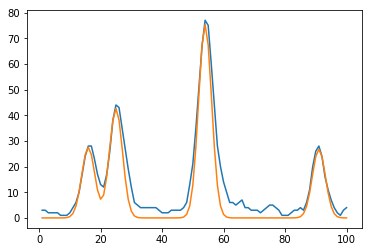

In [4]:
num_peaks_in = np.array(initial_params_in[0,-1])

WFtime = np.arange(1,244)
fit_wave_initial = NEON_AOP_waveform_tools.get_fit_wave(initial_params_in[0:1,0:-1],244,num_peaks_in)
plt.plot(WFtime[0:100],wave_in[0,1:101],WFtime[0:100],fit_wave_initial[0:100])
plt.show()

In [7]:
GaussianCalcTime = time.clock()
temp_out_params = NEON_AOP_waveform_tools.get_gaussian_params(initial_params_out,wave_out[0],10,20,1)[0]
print('Total time for Gaussian Decomposition is {}'.format(time.clock()-GaussianCalcTime))
print(temp_out_params)

GaussianCalcTime = time.clock()
temp_in_params = NEON_AOP_waveform_tools.get_gaussian_params(initial_params_in,wave_in[0],10,20,0)[0]
print('Total time for Gaussian Decomposition is {}'.format(time.clock()-GaussianCalcTime))

[[ 190.54389395   13.86565818    3.17755831]]
[[ 194.70743149   13.86221915    3.04838833]]
[[ 195.4279202    13.85881319    2.98760476]]
[[ 197.04748409   13.85775387    2.98723026]]
[[ 197.30933264   13.85716662    2.97862482]]
[[ 197.37204773   13.85702049    2.97905241]]
[[ 197.4845133    13.85699513    2.9793795 ]]
[[ 197.48561224   13.85695451    2.97959698]]
[[ 197.48564292   13.85695413    2.97960285]]
[[ 197.4856437    13.85695412    2.97960294]]
Total time for Gaussian Decomposition is 0.03494659523720145
[[ 197.4856437    13.85695412    2.97960294  191.34823356]]
1
Total time for Gaussian Decomposition is 0.02401574363928205


In [10]:
print(temp_in_params)

[[  28.43808381   17.31918722    3.32337252   43.14412998   26.59730156
     3.72736147   74.36492512   55.33189459    3.96359079   26.98299731
    91.88354827    3.33727948  889.92894769]]


In [12]:
fit_wave_final = NEON_AOP_waveform_tools.get_fit_wave(temp_in_params,244,num_peaks_in)

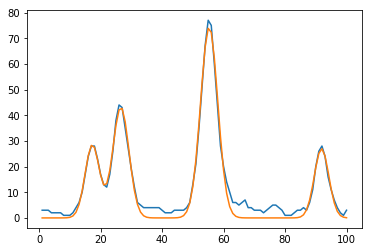

In [14]:
plt.plot(WFtime[0:100], wave_in[0,0:100],WFtime[0:100],fit_wave_final[0:100])
plt.show()

In [15]:
FWHM = (2.355*(temp_in_params[0,2:int(num_peaks_in*3):3]/2**0.5))/2

[[ 14.55208665]
 [ 23.49383243]
 [ 52.03173662]
 [ 89.10486852]]


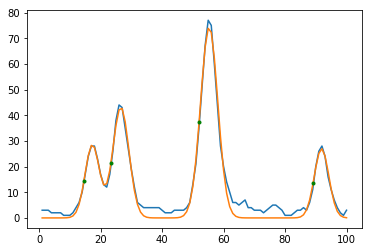

1


In [17]:
trig_loc = temp_in_params[0,1:int(num_peaks_in*3):3]-FWHM
trig_loc = np.reshape(trig_loc,(4,1))
print(trig_loc)
plt.plot(WFtime[0:100], wave_in[0,0:100],WFtime[0:100],fit_wave_final[0:100],trig_loc,temp_in_params[0,0:int(num_peaks_in*3):3]/2,'g.')
plt.show()
print(WFtime[0])

In [19]:
trig_loc = temp_in_params[0,1:int(num_peaks_in*3):3]-FWHM-temp_out_params[0,1]
trig_loc = np.reshape(trig_loc,(4,1))

In [21]:
pulse_coords = (np.matlib.repmat(trig_loc[:,0],3,1)).transpose()*coord_info[:,1:4]+coord_info[:,4:7]
print(pulse_coords)

[[  5.31528159e+05   4.31851701e+06   2.26791276e+03]
 [  5.31527791e+05   4.31851713e+06   2.26663044e+03]
 [  5.31526616e+05   4.31851753e+06   2.26253784e+03]
 [  5.31525089e+05   4.31851805e+06   2.25722122e+03]]


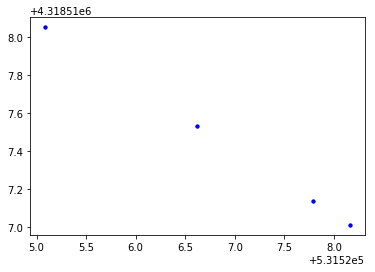

In [23]:
plt.plot(pulse_coords[:,0],pulse_coords[:,1],'b.')
plt.show()